In [4]:
# Graph
num_nodes = 4
start_node = 0
end_node = num_nodes - 1
edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
weights = {(0, 1): 5, (0, 2): 8, (1, 2): 2, (1, 3): 7, (2, 3): 4}
P = sum(weights.values()) + 1

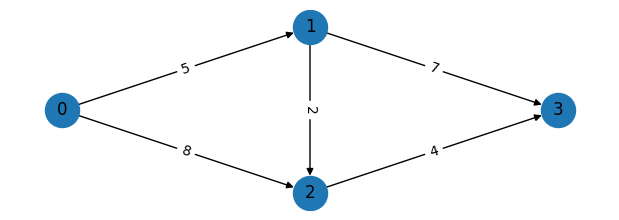

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Imprime un grafo dirigido pesado
# Entrada
#     graph_nodes: Lista de nodos del grafo
#     graph_edges: Diccionario {vértice: peso} donde vértice es (n1, n2)
#     layout:      Para especificar la posición de los nodos
def print_graph(graph_nodes, graph_edges, layout=None):
    G = nx.DiGraph()

    # Nodes
    G.add_nodes_from(graph_nodes)

    # Edges
    for pair, weight in graph_edges.items():
        G.add_edge(pair[0], pair[1], weight=weight)

    # Print graph
    if layout is None:
        layout = nx.spring_layout(G)

    plt.figure(3, figsize=(6, 2))
    nx.draw(G, layout, with_labels=True, node_size=600)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=edge_labels)

print_graph(range(num_nodes), weights, layout={0: [-1, 0], 1: [0, 1],
                                               2: [0, -1], 3: [1, 0]})

In [6]:
from dimod import BinaryQuadraticModel
# Initialize model
bqm = BinaryQuadraticModel("BINARY")

In [7]:
# Cost function
for e in range(len(edges)):
    bqm.add_variable(edges[e], weights[edges[e]])

In [8]:
# Constraint: Starting node (The path has to start)
c_start = []
for e in range(len(edges)):
    i, j = edges[e]  # i->j
    if i == start_node:
        c_start.append((edges[e], 1))

# (\sum_{c} c[0]*c[1]) + constant = 0
bqm.add_linear_equality_constraint(c_start, constant=-1, lagrange_multiplier=P)

In [9]:
# Constraint: Ending node
c_end = []
for e in range(len(edges)):
    i, j = edges[e]  # i->j
    if j == end_node:
        c_end.append((edges[e], 1))

bqm.add_linear_equality_constraint(c_end, constant=-1, lagrange_multiplier=P)

In [10]:
# Constraints: Intermediate nodes
for node in range(1, end_node):
    c_inter = []
    for e in range(len(edges)):
        i, j = edges[e]
        if j == node:
            c_inter.append((edges[e], 1))  # Entering edges
        elif i == node:
            c_inter.append((edges[e], -1))  # Exiting edges

    bqm.add_linear_equality_constraint(c_inter, constant=0,
                                       lagrange_multiplier=P)

In [11]:
from dwave.system import DWaveSampler, EmbeddingComposite
# Execute program
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1024)
print(sampleset)

  (0, 1) (0, 2) (1, 2) (1, 3) (2, 3) energy num_oc. chain_.
0      1      0      1      0      1   11.0     290     0.0
1      0      1      0      0      1   12.0     408     0.0
2      1      0      0      1      0   12.0     316     0.0
3      0      0      0      0      0   54.0       3     0.0
4      0      0      0      0      1   58.0       1     0.0
5      1      0      0      0      0   59.0       2     0.0
6      1      0      1      0      0   61.0       1     0.0
7      0      1      0      0      0   62.0       1     0.0
9      0      1      0      0      0   62.0       1     0.2
8      0      1      1      0      1   68.0       1     0.0
['BINARY', 10 rows, 1024 samples, 5 variables]
